<a href="https://colab.research.google.com/github/cyamax/time_series_forecast_lab/blob/main/Darts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install 'u8darts[all]'

In [5]:
!wget https://raw.githubusercontent.com/unit8co/darts/master/examples/AirPassengers.csv

--2020-10-21 15:03:19--  https://raw.githubusercontent.com/unit8co/darts/master/examples/AirPassengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1746 (1.7K) [text/plain]
Saving to: ‘AirPassengers.csv’

AirPassengers.csv   100%[===================>]   1.71K  --.-KB/s    in 0s      

2020-10-21 15:03:19 (31.1 MB/s) - ‘AirPassengers.csv’ saved [1746/1746]



In [8]:
import pandas as pd
from darts import TimeSeries

df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')
train, val = series.split_after(pd.Timestamp('19580101'))

In [9]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



Text(0.5, 0, 'Year')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


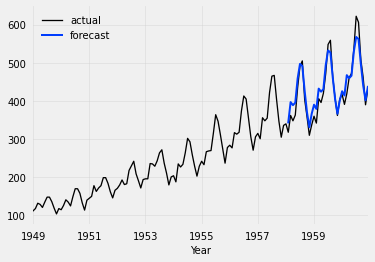

In [10]:
import matplotlib.pyplot as plt

series.plot(label='actual')
prediction.plot(label='forecast', lw=2)
plt.legend()
plt.xlabel('Year')